## Mount the google drive

In [155]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load the image to modify

In [156]:
from tensorflow import keras
import matplotlib.pyplot as plt

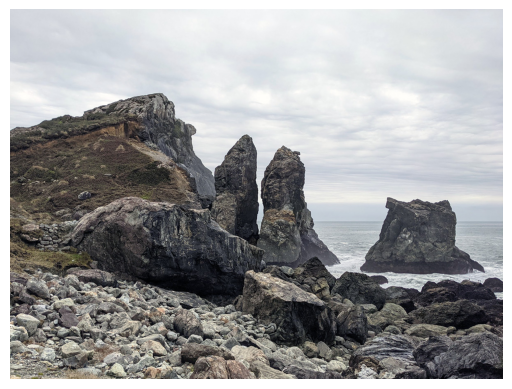

In [157]:
base_image_path = "/content/drive/MyDrive/Colab Notebooks/coast.jpg"

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

## Pre-trained Convnet
To implement DeepDream in Keras, the first step is acquiring a pretrained convolutional neural network (convnet). Keras offers various options, including VGG16, VGG19, Xception, and ResNet50, all preloaded with weights from ImageNet. The choice of the base model significantly impacts the resulting visualizations, as different architectures yield distinct learned features. Notably, the original DeepDream release employed an Inception model, known for producing aesthetically pleasing results. Consequently, the recommended choice for this implementation is the Inception V3 model provided by Keras.

In [158]:
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

We’ll use our pretrained convnet to create a feature extractor model that returns the activations of the various intermediate layers; For each layer, we pick a scalar score that weights the contribution of the layer to the loss we will seek to maximize during the gradient ascent process.

In [159]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_752 (Conv2D)         (None, None, None, 32)       864       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_752 (B  (None, None, None, 32)       96        ['conv2d_752[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_752 (Activation  (None, None, None, 32)       0         ['batch_normalizati

In [160]:
# Layers for which we try to maximize activation, as well as their weight in the total loss.
# You can tweak these setting to obtain new visual effects.

layer_settings = {
  "mixed3": 1.0,
  "mixed5": 1.0,
}

In [161]:
# Symbolic output of each layer
outputs_dict = dict([
    (layer.name, layer.output)
    for layer in [model.get_layer(name) for name in layer_settings.keys()]
])

In [162]:
outputs_dict

{'mixed3': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>}

In [163]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Next, we’ll compute the loss: the quantity we’ll seek to maximize during the gradient-ascent process at each processing scale. Here, we’ll simultaneously maximize the activation of all filters in a number of layers. Specifically, we’ll maximize a weighted mean of the L2 norm of the activations of a set of high-level layers.

The exact set of layers we choose (as well as their contribution to the final loss) has a major influence on the visuals we’ll be able to produce, so we want to make these parameters easily configurable. Lower layers result in geometric patterns, whereas higher layers result in visuals in which you can recognize some classes from ImageNet (for example, birds or dogs).

## Loss function

In [164]:
import tensorflow as tf

def compute_loss(input_image):
  features = feature_extractor(input_image) # extract activations
  loss = tf.zeros(shape=()) # initialize loss to zero
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

Now let’s set up the gradient ascent process that we will run at each octave.

##  The DeepDream gradient ascent process

In [165]:
@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss, image) # compute gradients of deep dream loss with respect to the current image
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss, image

In [166]:
# This runs gradient ascent for a given image scale (octave).
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
  for i in range(iterations): # repeatedly update the image in a way that increase the DeepDream loss.
    loss, image =  gradient_ascent_step(image, learning_rate)
    if max_loss is not None and loss > max_loss: # Break out if the loss crosses a certain threshold (over-optimizing would create unwanted image artifacts).
      break
    print(f"... Loss value at step {i}: {loss:.2f}")

  return image



Octaves=List of scales at which to proces  the images.
We’ll process our image over three different such “octaves.” For each successive octave, from the smallest to the largest, we’ll run 20 gradient ascent steps via gradient_ascent_loop() to maximize the loss we previously defined. Between each octave, we’ll upscale the image by 40% (1.4x): we’ll start by processing a small image and then increasingly scale it up.

![Screenshot from 04-12-23 18:23:53](https://github.com/surajkarki66/MediLeaf_backend/assets/50628520/6cdeaf79-6219-4a72-841a-013ef93bf6e2)


In [167]:
step = 20 # gradient ascent step size
num_octave = 3 # no. of scales at which to run gradient ascent
octave_scale = 1.4 # size ratio between successive scales
iterations = 30 # no. of gradient ascent steps per scale
max_loss = 15

In [168]:
import numpy as np

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

In [169]:
def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  img /= 2.0
  img += 0.5

  img *= 255.
  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [170]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img) # Make a copy of the image(we need to keep original around)

for i, shape in enumerate(successive_shapes):
  print(f"Processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img # The difference between the two is the detail that was lost when scaling up.
  img += lost_detail # Re-inject lost detail into the dream.
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))


Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.72
... Loss value at step 1: 0.93
... Loss value at step 2: 1.23
... Loss value at step 3: 1.58
... Loss value at step 4: 1.93
... Loss value at step 5: 2.28
... Loss value at step 6: 2.61
... Loss value at step 7: 2.96
... Loss value at step 8: 3.27
... Loss value at step 9: 3.59
... Loss value at step 10: 3.90
... Loss value at step 11: 4.21
... Loss value at step 12: 4.51
... Loss value at step 13: 4.80
... Loss value at step 14: 5.08
... Loss value at step 15: 5.35
... Loss value at step 16: 5.63
... Loss value at step 17: 5.89
... Loss value at step 18: 6.15
... Loss value at step 19: 6.41
... Loss value at step 20: 6.64
... Loss value at step 21: 6.89
... Loss value at step 22: 7.12
... Loss value at step 23: 7.34
... Loss value at step 24: 7.58
... Loss value at step 25: 7.80
... Loss value at step 26: 8.02
... Loss value at step 27: 8.24
... Loss value at step 28: 8.46
... Loss value at step 29: 8.66
Processi

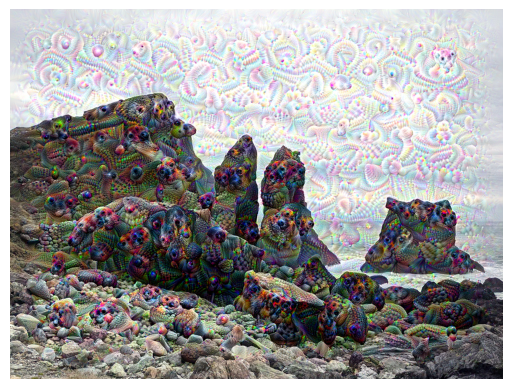

In [171]:
plt.axis("off")
plt.imshow(deprocess_image(img.numpy()))